In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from dates import *
from crdtrns import *
import matplotlib.pyplot as plt
import matplotlib.animation as animation

#In my case, I had to put the path for "EPSG", basemap will fail. --- 
#      It can be fixed, it is conda-forge packaging problem. Anyhow, ...
os.environ['PROJ_LIB'] = '/usr/share/proj'

from mpl_toolkits.basemap import Basemap

In [2]:
"""
I have dowloaded the station log information from (ftp://ftp.igs.org/pub/station/log/). 
One can directly download a .csv of which contains all stations from http://www.igs.org/network.
I had to download the .log info as it contains an information of when when each station was installed.

"""
#I have them here!

!ls ./igs/*.log

./igs/abmf_20200207.log  ./igs/ieng_20190927.log  ./igs/ptag_20180706.log
./igs/abpo_20200204.log  ./igs/iisc_20200203.log  ./igs/ptbb_20200305.log
./igs/acrg_20200325.log  ./igs/ineg_20170725.log  ./igs/ptgg_20200206.log
./igs/adis_20200324.log  ./igs/invk_20171117.log  ./igs/ptvl_20200303.log
./igs/aggo_20181206.log  ./igs/iqal_20190322.log  ./igs/qaq1_20200205.log
./igs/aira_20181226.log  ./igs/iqqe_20171121.log  ./igs/qiki_20140808.log
./igs/ajac_20200123.log  ./igs/irkj_20170130.log  ./igs/qui3_20160311.log
./igs/albh_20190307.log  ./igs/irkm_20190617.log  ./igs/qui4_20160311.log
./igs/algo_20190408.log  ./igs/irkt_20050608.log  ./igs/quin_20190530.log
./igs/alic_20191022.log  ./igs/isba_20200106.log  ./igs/rabt_20190618.log
./igs/alrt_20130117.log  ./igs/ishi_20181227.log  ./igs/raeg_20200327.log
./igs/amc4_20200206.log  ./igs/ispa_20170502.log  ./igs/ramo_20190203.log
./igs/ankr_20191224.log  ./igs/ista_20181211.log  ./igs/rbay_20170821.log
./igs/anmg_20190516.log  ./igs/izmi_20

In [3]:
#lets grab the required information

installed, lat, lon, country, city, stid = [[] for i in range(6)]

for file in sorted(list(glob.glob('./igs/*.log'))):
    
    f = open(file, 'r')
    
    for lines in f:
        if lines[0:19] == '     Date Installed':
            inst = lines.split()[3][0:10]
        if lines[0:28] == '     Geologic Characteristic':
            installed.append(inst)
        if lines[0:19] == '       X coordinate':
            X = float(lines.split()[4])
        if lines[0:19] == '       Y coordinate':
            Y = float(lines.split()[4])
        if lines[0:19] == '       Z coordinate':
            Z = float(lines.split()[4])
            #my own function (crdtrns.py, imported above) to calculate lat and lon
            lt, ln, h = xyz2latlonh(float(X), float(Y), float(Z) ) 
            
            lat.append(lt*180/np.pi)
            lon.append(ln*180/np.pi)
        if lines[0:12] == '     Country':
            country.append(str(lines[32:]))
        if lines[0:22] == '     Four Character ID':
            stid.append(str(lines[32:36]))
        if lines[0:17] == '     City or Town':
            city.append(str(lines[32:]))

        
    f.close()

In [4]:
#I would like to creat a dataframe

columns = ["stid",  "lat", 'lon', "installed", "Country", 'City']

df = pd.DataFrame(list(zip(stid, lat, lon, installed, country, city)), columns=columns)

df['installed'] = pd.to_datetime(df['installed'])
df['Country'] = df['Country'].str.strip()
df['City'] = df['City'].str.strip()

df['year'] = pd.DatetimeIndex(df.installed).year
df['month'] = pd.DatetimeIndex(df.installed).month
df['day'] = pd.DatetimeIndex(df.installed).day

#just calculating the decimal year using one of my functions (dates.py, imported above)

df['decYr'] = df[['year','month', 'day']].apply(lambda x: decimalYear2(*x), axis=1) 

In [5]:
#I would like to sort my df by year of installation
df = df.sort_values(by='decYr')

In [6]:
df.head()

,stid,lat,lon,installed,Country,City,year,month,day,decYr
28,BAKO,-6.491055,106.848910,1981-06-12,Indonesia,Cibinong,1981,6,12,1981.445205
348,QUIN,39.974554,-120.944429,1982-01-01,United States,Quincy,1982,1,1,1982.001370
204,KOKV,22.126264,-159.664930,1987-01-01,United States of America,"Kokee Park, Waimea,",1987,1,1,1987.001370
203,KOKB,22.126264,-159.664930,1987-01-01,United States,"Kokee Park, Waimea,",1987,1,1,1987.001370
506,ZIMM,46.877095,7.465273,1988-03-01,Switzerland,Zimmerwald,1988,3,1,1988.165301


<IPython.core.display.Javascript object>


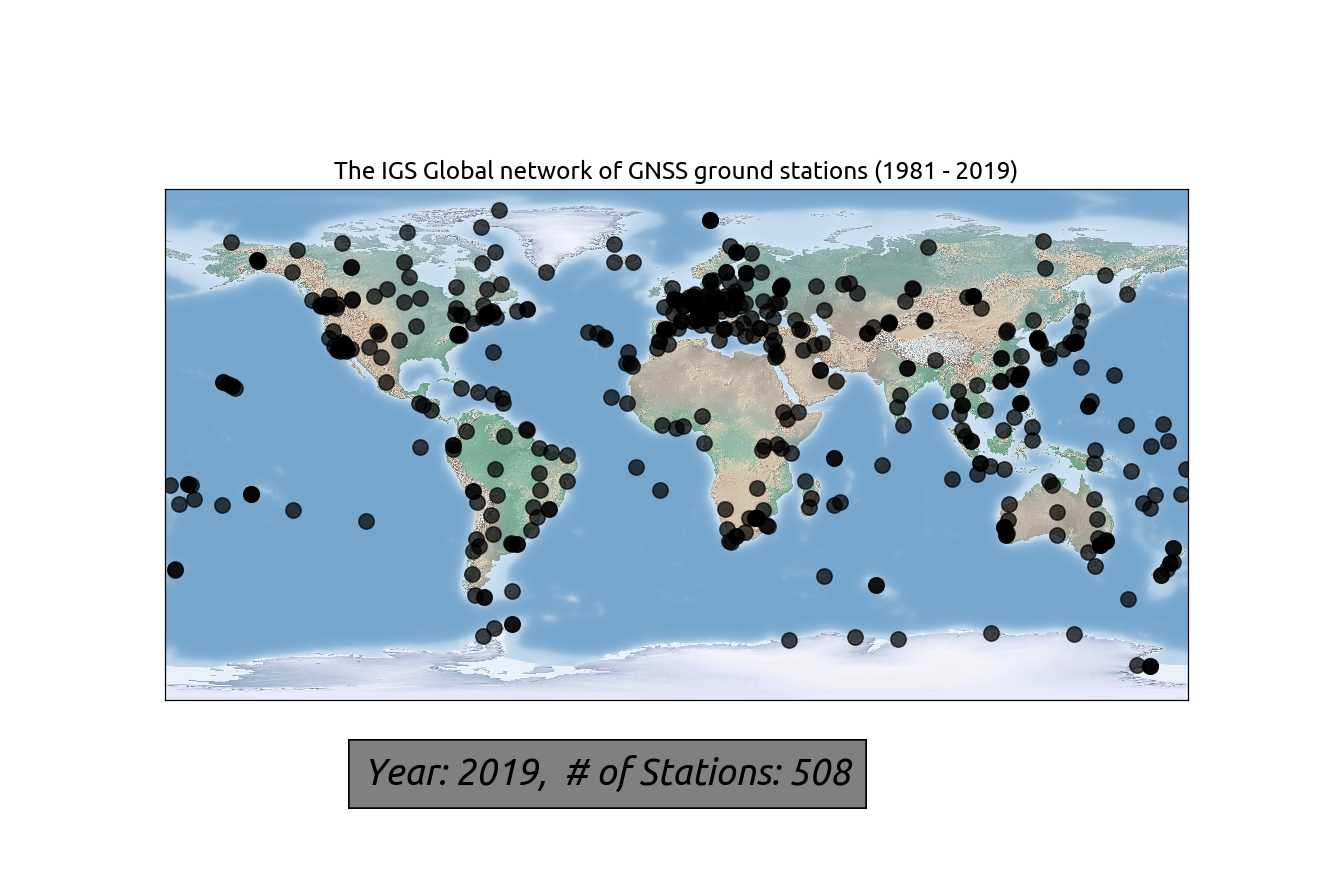

In [7]:
%matplotlib notebook
%matplotlib notebook
#
#matplotlib.use("Agg") #uncomment this for saving
fig, ax = plt.subplots(figsize=(12, 8))

m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=-90, urcrnrlat=90,
            llcrnrlon=-180, urcrnrlon=180, )
m.etopo(scale=.5, alpha=0.5)
m.shadedrelief(scale=0.5)

#initialize
lat = 0
lon = 0
#plot
lon, lat = m(lon, lat)
plot1, = ax.plot(lon, lat,  'ok', markersize=10, alpha=0.7)
 
plt.title('The IGS Global network of GNSS ground stations (1981 - 2019)', fontsize=16, fontname='Ubuntu')
stns=0

def animate(i):
    data = df.iloc[:int(i+1)] #select data range
    
    lat = data['lat'].values
    lon = data['lon'].values
    
    plot1.set_data(lon, lat)
    
    yrs = np.max(data['year'].values)
    
    #This loop makes it slow
    
#    for yr in df['year'].values:
#    stns += 1
#    plt.text(-110, -120, ("Year: {},  # of Stations: {} ".format(yr, stns)), style='italic',
#             fontsize=24, fontname='Ubuntu',
#             bbox={'facecolor':'grey', 'alpha':10, 'pad':10})

#instead of the loop, I tricked it in a way

    stns = len(lat)
    plt.text(-110, -120, ("Year: {},  # of Stations: {}".format(yrs, stns)), style='italic',
         fontsize=24, fontname='Ubuntu',
         bbox={'facecolor':'grey', 'alpha':10, 'pad':10})

    return plot1

ani = animation.FuncAnimation(fig, animate, frames=len(df['year']), interval=1, repeat=False, blit=False )
#uncomment this for saving
#ani.save("igs_gnss_network.mp4", fps=15, bitrate=1800)

----


----

In [ ]:
"!"